<a href="https://colab.research.google.com/github/meduardajustino/Analise-com-Dados-da-POF-2017-2018/blob/main/Script_R_Regional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c(
  "tidyverse",    # dplyr, ggplot2, etc
  "readr",        # para importar CSV
  "broom",        # para extrair coeficientes do modelo
  "srvyr",        # se quiser aplicar pesos corretamente
  "modelsummary",  # para exibir tabelas de regressão
  "readxl"       # para importar arquivos Excel
))

library(tidyverse)
library(broom)
library(modelsummary)
library(readxl) # Carregar o pacote readxl

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘RcppArmadillo’, ‘bayestestR’, ‘datawizard’, ‘survey’, ‘checkmate’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’, ‘tinytable’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Rows: 1983 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): subitem, cod_subitem, grupo
dbl (6): cod, uf, precom, partic, rm, peso

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 169
Columns: 9
$ cod         <dbl> 2201003, 2103032, 2201005, 2103039, 2104009, 2101012, 2104…
$ uf          <dbl> 50, 31, 33, 29, 50, 23, 29, 35, 52, 35, 35, 26, 43, 26, 31…
$ precom      <dbl> 2.7707598, 15.2152463, 96.2000000, 0.5845900, 6.9443061, 6…
$ subitem     <chr> "Carvão vegetal", "Revestimento de piso e parede", "Gás en…
$ cod_subitem <chr> "02201003", "02103032", "02201005", "02103039", "02104009"…
$ grupo       <chr> "habitacao", "habitacao", "habitacao", "habitacao", "habit…
$ partic      <dbl> 0.00, 0.11, 0.43, 0.07, 0.35, 0.00, 0.24, 4.55, 2.36, 3.78…
$ rm          <dbl> 5, 3, 3, 2, 5, 2, 2, 3, 5, 3, 3, 2, 4, 2, 3, 1, 4, 3, 2, 2…
$ peso        <dbl> 0.000000000, 0.001177730, 0.004863704, 0.000742745, 0.0037…


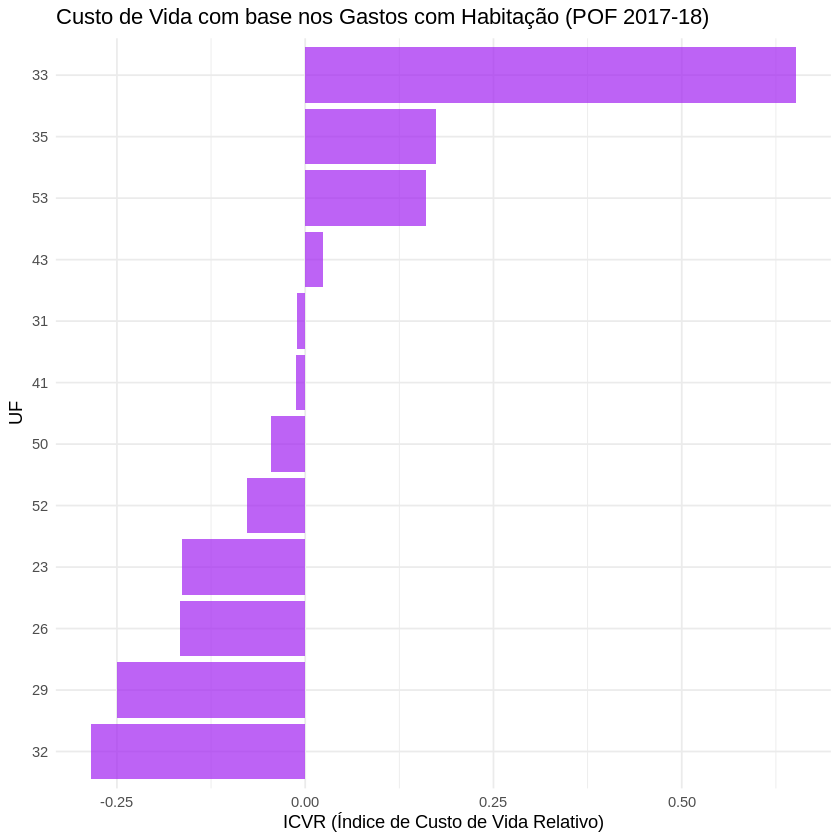

In [5]:

# Definir diretório e importar os dados
df <- read_csv("/content/ipc_gastos pof 2017-2018 aula.csv")
# Filtrar apenas o grupo "Habitação"
df <- df %>%
  filter(str_to_lower(grupo) == "habitacao")

glimpse(df)

# Criar log do preço
df <- df %>%
  mutate(lnp = log(precom))

# Criar dummies para grupos (produto) e estados (UF)
df <- df %>%
  mutate(across(c(cod, uf), as.factor)) %>%
  mutate(across(c(cod, uf), ~ factor(.))) %>%
  mutate(peso = as.numeric(peso))

# Rodar regressão CPD (Country-Product Dummy)
modelo <- lm(lnp ~ cod + uf, data = df, weights = peso)

# Ver coeficientes por UF
coefs <- tidy(modelo) %>%
  filter(str_detect(term, "uf")) %>%
  mutate(uf = str_remove(term, "uf")) %>%
  mutate(uf = as.numeric(uf)) %>%
  rename(coef = estimate) %>%
  mutate(ecoef = exp(coef)) %>%
  mutate(m_ecoef = mean(ecoef),
         icvr = (ecoef / m_ecoef) - 1)

# Reduzir para tabela final por UF
tabela_icvr <- coefs %>%
  select(uf, icvr) %>%
  arrange(desc(icvr))

# Visualização opcional
ggplot(tabela_icvr, aes(x = reorder(as.factor(uf), icvr), y = icvr)) +
  geom_col(fill = "purple", alpha = 0.7) +
  coord_flip() +
  labs(x = "UF", y = "ICVR (Índice de Custo de Vida Relativo)",
       title = "Custo de Vida com base nos Gastos com Habitação (POF 2017-18)") +
  theme_minimal()


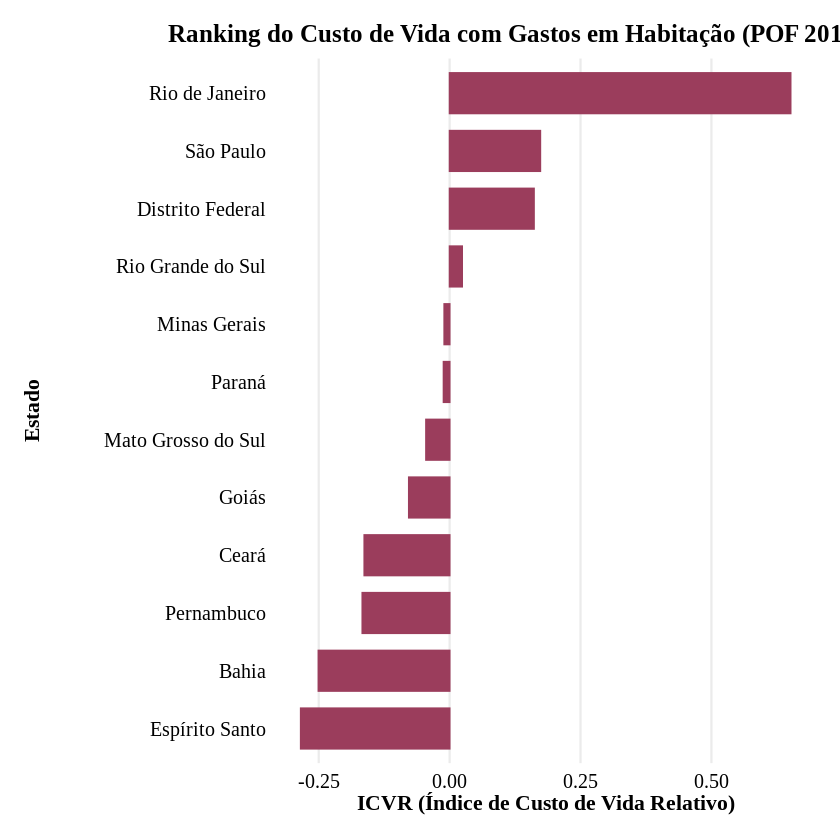

In [19]:
# Visualizações para facilitar a escrita do trabalho

# correspondência UF x Estado
ufs_nomes <- tibble(
  uf = c(11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 41, 42, 43, 50, 51, 52, 53),
  estado = c("Rondônia", "Acre", "Amazonas", "Roraima", "Pará", "Amapá", "Tocantins",
             "Maranhão", "Piauí", "Ceará", "Rio Grande do Norte", "Paraíba", "Pernambuco",
             "Alagoas", "Sergipe", "Bahia", "Minas Gerais", "Espírito Santo", "Rio de Janeiro",
             "São Paulo", "Paraná", "Santa Catarina", "Rio Grande do Sul", "Mato Grosso do Sul",
             "Mato Grosso", "Goiás", "Distrito Federal")
)

# juntar com a tabela_icvr
tabela_icvr_estados <- tabela_icvr %>%
  left_join(ufs_nomes, by = "uf") %>%
  arrange(desc(icvr))

# tabela dos coefs com uf
coefs_estados <- coefs %>%
  left_join(ufs_nomes, by = "uf") %>%
  arrange(desc(icvr))

library(ggplot2)
library(readr)

# Criação do gráfico com ajustes estéticos
plot_icvr_estados <- ggplot(tabela_icvr_estados, aes(x = reorder(estado, icvr), y = icvr)) +
  geom_col(fill = "#9b3d5c", color = "#9b3d5c", width = 0.7) +
  coord_flip() +
  labs(
    title = "Ranking do Custo de Vida com Gastos em Habitação (POF 2017-2018)",
    x = "Estado",
    y = "ICVR (Índice de Custo de Vida Relativo)"
  ) +
  theme_minimal(base_family = "serif", base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 15, color = "black"),
    axis.title = element_text(size = 13, face = "bold"),
    axis.text = element_text(color = "black", size = 12),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = margin(15, 15, 15, 15)
  )

# Exibir o gráfico
print(plot_icvr_estados)

# Salvar o gráfico com dimensões ampliadas
ggsave(
  "ranking_icvr_habitacao.png",
  plot = plot_icvr_estados,
  width = 12,        # aumentada a largura
  height = 6,       # altura proporcional
  dpi = 300,
  units = "in",
  bg = "white"
)

In [11]:
View(coefs_estados)

term,coef,std.error,statistic,p.value,uf,ecoef,m_ecoef,icvr,estado
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
uf33,0.591976126,0.07725085,7.6630366,3.458198e-10,33,1.8075568,1.094665,0.65124200,Rio de Janeiro
uf35,0.250154878,0.06667342,3.7519434,4.301624e-04,35,1.2842243,1.094665,0.17316647,São Paulo
uf53,0.239776206,0.08300810,2.8885882,5.558283e-03,53,1.2709647,1.094665,0.16105353,Distrito Federal
uf43,0.114006943,0.20486022,0.5565109,5.801607e-01,43,1.1207599,1.094665,0.02383824,Rio Grande do Sul
uf31,0.080141213,0.07121687,1.1253122,2.654336e-01,31,1.0834401,1.094665,-0.01025425,Minas Gerais
uf41,0.078800979,0.07282636,1.0820393,2.840435e-01,41,1.0819890,1.094665,-0.01157985,Paraná
uf50,0.044324510,0.06456240,0.6865376,4.953118e-01,50,1.0453215,1.094665,-0.04507635,Mato Grosso do Sul
uf52,0.009361664,0.08406701,0.1113595,9.117441e-01,52,1.0094056,1.094665,-0.07788629,Goiás
uf23,-0.087422264,0.07446594,-1.1739900,2.455508e-01,23,0.9162901,1.094665,-0.16294932,Ceará


In [16]:
coefs_tabela <- coefs_estados %>%
  select(estado, coef, std.error, ecoef, icvr, p.value)

View(coefs_tabela)

estado,coef,std.error,ecoef,icvr,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rio de Janeiro,0.591976126,0.07725085,1.8075568,0.65124200,3.458198e-10
São Paulo,0.250154878,0.06667342,1.2842243,0.17316647,4.301624e-04
Distrito Federal,0.239776206,0.08300810,1.2709647,0.16105353,5.558283e-03
Rio Grande do Sul,0.114006943,0.20486022,1.1207599,0.02383824,5.801607e-01
Minas Gerais,0.080141213,0.07121687,1.0834401,-0.01025425,2.654336e-01
Paraná,0.078800979,0.07282636,1.0819890,-0.01157985,2.840435e-01
Mato Grosso do Sul,0.044324510,0.06456240,1.0453215,-0.04507635,4.953118e-01
Goiás,0.009361664,0.08406701,1.0094056,-0.07788629,9.117441e-01
Ceará,-0.087422264,0.07446594,0.9162901,-0.16294932,2.455508e-01


In [12]:
View(tabela_icvr_estados)

uf,icvr,estado
<dbl>,<dbl>,<chr>
33,0.65124200,Rio de Janeiro
35,0.17316647,São Paulo
53,0.16105353,Distrito Federal
43,0.02383824,Rio Grande do Sul
31,-0.01025425,Minas Gerais
41,-0.01157985,Paraná
50,-0.04507635,Mato Grosso do Sul
52,-0.07788629,Goiás
23,-0.16294932,Ceará


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’


Loading required namespace: sf

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE

Using year/date 2020



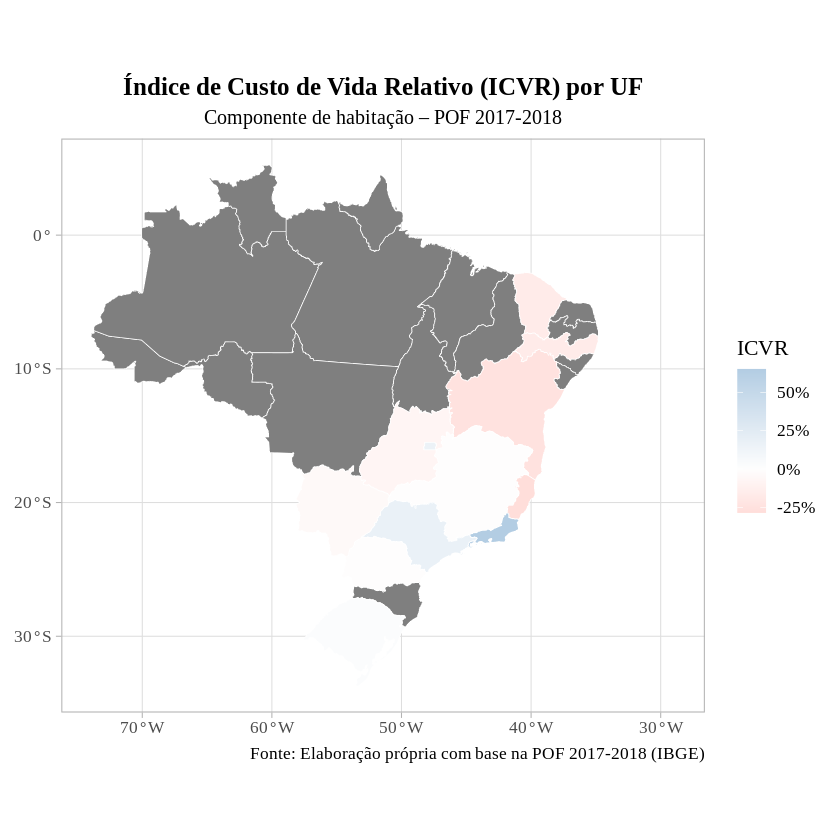

In [13]:
#Nova forma de visualização - mapa do Brasil
install.packages(c("geobr", "sf", "ggplot2", "dplyr"))

# Pacotes
library(geobr)
library(sf)
library(ggplot2)
library(dplyr)
library(readr)
library(broom)      # se usar tidy(modelo)
library(stringr)

Using year/date 2020



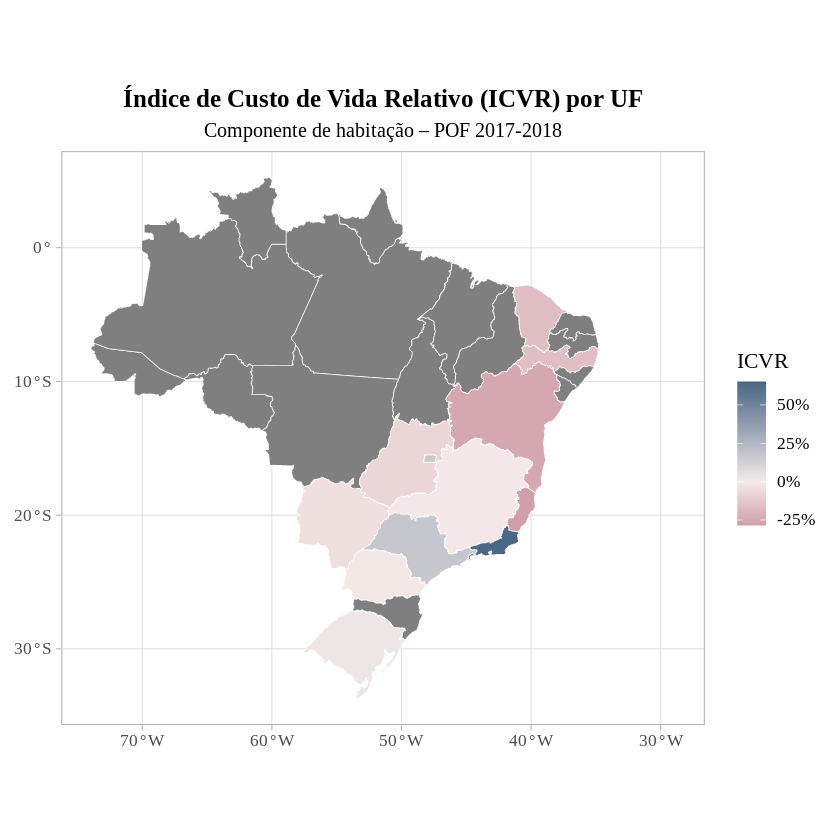

In [18]:
# Coeficientes e cálculo do ICVR
tabela_icvr <- tidy(modelo) %>%
  filter(str_detect(term, "uf")) %>%
  mutate(
    uf = str_remove(term, "uf"),
    uf = as.integer(uf),
    coef = estimate,
    ecoef = exp(coef),
    m_ecoef = mean(ecoef),
    icvr = (ecoef / m_ecoef) - 1
  ) %>%
  select(uf, icvr)

# Mapa das UFs
mapa_uf <- read_state(year = 2020)

# Merge: mapa + dados
mapa_icvr_dados <- mapa_uf %>%
  left_join(tabela_icvr, by = c("code_state" = "uf"))

# Plot do mapa com estilo pastel + serif
mapa_icvr <- ggplot(mapa_icvr_dados) +
  geom_sf(aes(fill = icvr), color = "white", size = 0.2) +
  scale_fill_gradient2(
     low = "#9b3d5c", mid = "#f4ebe9", high = "#4a6785",
    midpoint = 0,
    name = "ICVR",
    labels = scales::percent_format(accuracy = 1)
  ) +
  labs(
    title = "Índice de Custo de Vida Relativo (ICVR) por UF",
    subtitle = "Componente de habitação – POF 2017-2018",
  ) +
  theme_light(base_size = 13, base_family = "serif") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 15, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    legend.position = "right"
  )

# Exibir
print(mapa_icvr)

# Salvar com dimensões apropriadas (em polegadas)
ggsave("mapa_icvr_habitacao.png", plot = mapa_icvr, width = 8, height = 8, units = "in", dpi = 300)